<a href="https://colab.research.google.com/github/bmwise14/NES_Salad/blob/main/notebooks/240507_VisWords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import BertModel, BertTokenizer
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import torch
import plotly.express as px

In [5]:
from google.colab import files
uploaded = files.upload()
# titles = pd.read_csv("../data/nes_titles.csv")['Title']
titles = pd.read_csv("./nes_titles.csv")['Title']

Saving nes_titles.csv to nes_titles (1).csv


In [6]:
titles.head()

0                            '89 Dennou Kyuusei Uranai
1                                        10-Yard Fight
2                                                 1942
3    1943: The Battle of Midway 1943: The Battle of...
4                  1999: Hore Mita Koto Ka! Seikimatsu
Name: Title, dtype: object

In [7]:
word_to_index = {}
index_to_word = {}
for title in titles:
    for word in title.split():
        if word not in word_to_index:
            index = len(word_to_index)
            word_to_index[word] = index
            index_to_word[index] = word
words = list(word_to_index.keys())

### Create Embedding from BERT Tokenizer

In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/Users/bradleywise/Envs/nes_salad/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



In [ ]:
# Select words you want to visualize
# words = ['king', 'queen', 'man', 'woman', 'doctor', 'nurse']
words = list(word_to_index.keys())

# Extract word embeddings
word_embeddings = []
for word in words:
    inputs = tokenizer(word, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    word_embeddings.append(embeddings)

word_embeddings = np.array(word_embeddings)

In [ ]:
word_embeddings.shape

(2710, 768)

In [ ]:
with open('../data/BERT_embeddings.npy', 'wb') as f:
    np.save(f, word_embeddings)

### Preloaded

In [8]:
from google.colab import files
uploaded = files.upload()
# word_embeddings = np.load('../data/BERT_embeddings.npy')
word_embeddings = np.load('./BERT_embeddings.npy')
word_embeddings.shape

Saving BERT_embeddings.npy to BERT_embeddings.npy


(2710, 768)

In [9]:
# Reduce dimensionality to 3D using t-SNE
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
word_embeddings_3d = tsne.fit_transform(word_embeddings)
word_embeddings_3d.shape

(2710, 3)

In [16]:
shuffled_indices = np.random.permutation(len(words))
num_rows_to_sample = 500

# Take the first 500 shuffled indices to get the sampled rows and words
sampled_rows = word_embeddings_3d[shuffled_indices[:num_rows_to_sample]]
sampled_words = [words[i] for i in shuffled_indices[:num_rows_to_sample]]

In [18]:
print(word_embeddings_3d.shape)
print(sampled_rows.shape)

(2710, 3)
(500, 3)


In [19]:
# sample_indices = np.random.choice(len(word_embeddings_3d), size=10, replace=False)

In [20]:
fig = px.scatter_3d(x=sampled_rows[:, 0], y=sampled_rows[:, 1],
                    z=sampled_rows[:, 2], text=sampled_words)
fig.show()

### Use DB Scan to give each set of words a relationship to each other in 3d Space
- might make it easier to visualize
- https://stackoverflow.com/questions/43160240/how-to-plot-a-k-distance-graph-in-python

In [27]:
import matplotlib.pyplot as plt

In [36]:
word_embeddings_3d[0]
np.linalg.norm(word_embeddings_3d[0], 2)

28.888847

In [40]:
# def cosine_similarity(vector1, vector2):
#     """
#     Compute cosine similarity between two vectors.

#     Parameters:
#     vector1 (numpy.ndarray): First vector.
#     vector2 (numpy.ndarray): Second vector.

#     Returns:
#     float: Cosine similarity between the two vectors.
#     """
#     dot_product = np.dot(vector1, vector2)
#     norm_vector1 = np.linalg.norm(vector1, 2) # use l2 norm
#     norm_vector2 = np.linalg.norm(vector2, 2) # use l2 norm
#     similarity = dot_product / (norm_vector1 * norm_vector2)
#     return similarity
# def cosine_similarity_matrix(data):
#     """
#     Compute cosine similarity matrix for a dataset.

#     Parameters:
#     data (numpy.ndarray): Dataset where each row represents a data point.

#     Returns:
#     numpy.ndarray: Cosine similarity matrix.
#     """
#     num_samples = len(data)
#     similarity_matrix = np.zeros((num_samples, num_samples))

#     for i in range(num_samples):
#         for j in range(num_samples):
#             similarity_matrix[i, j] = 1 - cosine_similarity(data[i], data[j]) # distance measure

#     return similarity_matrix
# distance = cosine_similarity_matrix(word_embeddings_3d)

In [42]:
def calculate_kn_distance(X, k):
    kn_distance = []
    for i in range(len(X)):
        cosine_similarities = []
        for j in range(len(X)):
            if i != j:  # Skip computing similarity with itself
                cosine_similarities.append(np.dot(X[i], X[j]) / (np.linalg.norm(X[i]) * np.linalg.norm(X[j])))

        cosine_similarities.sort(reverse=True)
        kn_distance.append(1 - cosine_similarities[k-1])  # k-1 to get k-th nearest neighbor (0-indexed)

    return kn_distance

In [43]:
eps_dist = calculate_kn_distance(word_embeddings_3d, 5)

In [50]:
print(np.mean(eps_dist))
print(np.median(eps_dist))

0.0028888600998699006
0.001933664083480835


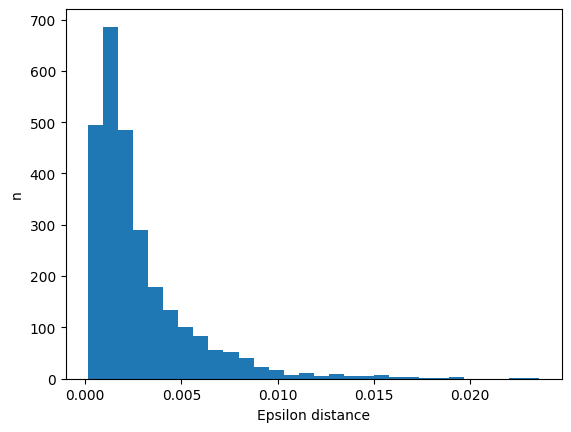

In [45]:
plt.hist(eps_dist,bins=30)
plt.ylabel('n');
plt.xlabel('Epsilon distance');

In [44]:
from sklearn.cluster import DBSCAN

In [23]:
word_embeddings_3d.shape

(2710, 3)

In [112]:
clustering = DBSCAN(eps=0.01, min_samples=20, metric='cosine').fit(word_embeddings_3d)

In [113]:
pd.DataFrame(clustering.labels_, columns=['label'])['label'].value_counts()

label
 1     639
-1     634
 0     588
 3     229
 2     130
 7      98
 4      92
 6      79
 5      78
 10     40
 8      34
 11     20
 9      19
 12     17
 13     13
Name: count, dtype: int64

In [114]:
clustering.labels_

array([-1,  0,  0, ...,  0,  0,  0])

In [117]:
shuffled_indices = np.random.permutation(len(words))
num_rows_to_sample = 2710

# Take the first N shuffled indices to get the sampled rows and words
sampled_rows = word_embeddings_3d[shuffled_indices[:num_rows_to_sample]]
sampled_words = [words[i] for i in shuffled_indices[:num_rows_to_sample]]
sampled_labels = [clustering.labels_[i] for i in shuffled_indices[:num_rows_to_sample]]

In [118]:
fig = px.scatter_3d(x=sampled_rows[:, 0], y=sampled_rows[:, 1],
                    z=sampled_rows[:, 2], text=sampled_words, color=sampled_labels)
fig.show()

In [ ]:
# import plotly.graph_objects as go

# # Assuming word_embeddings_3d is a numpy array containing your word embeddings
# # and words is a list of corresponding words

# # Create 3D scatter plot
# fig = go.Figure(data=[go.Scatter3d(
#     x=word_embeddings_3d[:, 0],
#     y=word_embeddings_3d[:, 1],
#     z=word_embeddings_3d[:, 2],
#     mode='markers',
#     marker=dict(
#         size=8,
#         color='rgb(0,0,255)',  # Change color if needed
#     ),
#     text=words,  # Assign words as text
# )])

# # Add annotations
# annotations = []
# for i, word in enumerate(words):
#     annotation = dict(
#         x=word_embeddings_3d[i, 0],
#         y=word_embeddings_3d[i, 1],
#         z=word_embeddings_3d[i, 2],
#         text=word,
#         showarrow=False,
#         font=dict(
#             color='black',  # Adjust font color if needed
#             size=12,
#         ),
#     )
#     annotations.append(annotation)

# fig.update_layout(
#     scene=dict(
#         annotations=annotations,
#     ),
# )

# fig.show()
